In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math


def compare_tensors_with_viz(tensor1, tensor2, save_path="tensor_diff.png", show=True):
    tensor1 = tensor1.detach().cpu()
    tensor2 = tensor2.detach().cpu()
    
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Tensor shapes must match: {tensor1.shape} vs {tensor2.shape}")
    
    abs_diff = torch.abs(tensor1 - tensor2)
    max_abs = torch.maximum(torch.abs(tensor1), torch.abs(tensor2))
    relative_diff = abs_diff / (max_abs + 1.0)
    
    top5_values, top5_indices = torch.topk(relative_diff.flatten(), min(5, relative_diff.numel()))
    
    print("Top 5 relative differences:")
    for i, (val, idx) in enumerate(zip(top5_values, top5_indices)):
        multi_idx = np.unravel_index(idx.item(), relative_diff.shape)
        print(f"  {i+1}. Value: {val.item():.6e} at index {multi_idx}")
    
    diff_flat = relative_diff.flatten()
    n = diff_flat.numel()
    
    side = math.ceil(math.sqrt(n))
    total_size = side * side
    
    if n < total_size:
        padding = torch.zeros(total_size - n)
        diff_flat = torch.cat([diff_flat, padding])
    
    diff_2d = diff_flat.reshape(side, side)
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(diff_2d.numpy(), cmap='hot', interpolation='nearest', vmin=0, vmax=0.05)
    plt.colorbar(im, label='Relative Difference')
    plt.title(f'Tensor Relative Difference (scale: 0-5%)\nOriginal shape: {tensor1.shape}, Reshaped to: {diff_2d.shape}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #print(f"\nImage saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()
    
    return relative_diff, diff_2d


In [2]:
import torch
import ttml

2026-01-12 04:09:15.471 | DEBUG    | ttnn:<module>:77 - Initial ttnn.CONFIG:
Config{cache_path=/home/ubuntu/.cache/ttnn,model_cache_path=/home/ubuntu/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=true,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


In [3]:

def pytorch_rmsnorm(x, gamma, epsilon):
    x_float = x.float()
    variance = x_float.pow(2).mean(-1, keepdim=True)
    x_normed = x_float * torch.rsqrt(variance + epsilon)
    return (gamma * x_normed).to(x.dtype)

In [4]:
shape = (1, 1, 32, 32 * 32)
seed = 42
epsilon = 1.0e-6
use_composite = False
atol = 0.01
rtol = 0.01

In [5]:
batch_size, _, seq_len, features = shape
torch.manual_seed(seed)
x = torch.randn(shape).to(torch.bfloat16).float()
gamma = torch.randn(1, 1, 1, features).to(torch.bfloat16).float()
grad_output = torch.randn(shape).to(torch.bfloat16).float()
x_pt = x.clone().requires_grad_(True)
gamma_pt = gamma.squeeze().clone().requires_grad_(True)
output_pt = pytorch_rmsnorm(x_pt, gamma_pt, epsilon)
output_pt.backward(grad_output)
x_ttml = ttml.autograd.Tensor.from_numpy(x.float().numpy(), ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)
gamma_ttml = ttml.autograd.Tensor.from_numpy(gamma.float().numpy(), ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16)
if use_composite:
    output_ttml = ttml.ops.rmsnorm.rmsnorm_composite(x_ttml, gamma_ttml, epsilon)
else:
    output_ttml = ttml.ops.rmsnorm.rmsnorm(x_ttml, gamma_ttml, epsilon)
output_ttml.set_grad_from_tensor(
    ttml.autograd.Tensor.from_numpy(
        grad_output.float().numpy(), ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
    )
)
output_ttml.backward(False)
output_ttml_t = output_ttml.get_value().cpu().to_torch().float()
x_grad_ttml_t = x_ttml.get_grad().cpu().to_torch().float()
gamma_grad_ttml_t = gamma_ttml.get_grad().cpu().to_torch().float()
gamma_grad_pt = gamma_pt.grad.reshape(1, 1, 1, features)
assert output_ttml_t.shape == output_pt.shape, f"Output shape mismatch: {output_ttml_t.shape} vs {output_pt.shape}"
assert torch.allclose(
    output_ttml_t, output_pt.float().detach(), atol=atol, rtol=rtol
), f"Forward mismatch: max diff = {(output_ttml_t - output_pt.detach()).abs().max()}"
assert x_grad_ttml_t.shape == x_pt.grad.shape, f"X grad shape mismatch: {x_grad_ttml_t.shape} vs {x_pt.grad.shape}"
assert torch.allclose(
    x_grad_ttml_t, x_pt.grad.float(), atol=atol, rtol=rtol
), f"X grad mismatch: max diff = {(x_grad_ttml_t - x_pt.grad).abs().max()}"
assert (
    gamma_grad_ttml_t.shape == gamma_grad_pt.shape
), f"Gamma grad shape mismatch: {gamma_grad_ttml_t.shape} vs {gamma_grad_pt.shape}"
assert torch.allclose(
    gamma_grad_ttml_t, gamma_grad_pt.float(), atol=atol, rtol=rtol
), f"Gamma grad mismatch: max diff = {(gamma_grad_ttml_t - gamma_grad_pt).abs().max()}"
ttml.autograd.AutoContext.get_instance().reset_graph()


2026-01-12 04:09:15.995 | info     |             UMD | Established firmware bundle version: 19.4.0 (topology_discovery.cpp:369)
2026-01-12 04:09:15.995 | info     |             UMD | Firmware bundle version 19.4.0 on the system is newer than the latest fully tested version 19.1.0 for wormhole_b0 architecture. Newest features may not be supported. (topology_discovery.cpp:395)
2026-01-12 04:09:15.995 | warning  |             UMD | ETH FW version mismatch for chip 0 ETH core CoreCoord: (9, 0, ETH, NOC0), found: 7.2.0. (topology_discovery_wormhole.cpp:347)
2026-01-12 04:09:15.995 | warning  |             UMD | Skipping discovery from chip 0 ETH core CoreCoord: (9, 0, ETH, NOC0) (topology_discovery.cpp:164)
2026-01-12 04:09:15.995 | warning  |             UMD | ETH FW version mismatch for chip 0 ETH core CoreCoord: (1, 0, ETH, NOC0), found: 7.2.0. (topology_discovery_wormhole.cpp:347)
2026-01-12 04:09:15.995 | warning  |             UMD | Skipping discovery from chip 0 ETH core CoreCoord: (

AssertionError: Gamma grad mismatch: max diff = 0.09387969970703125

In [6]:
(output_ttml_t - output_pt).abs().mean(), (output_ttml_t - output_pt).abs().max()

(tensor(0.0015, grad_fn=<MeanBackward0>),
 tensor(0.0360, grad_fn=<MaxBackward1>))

In [7]:
(x_pt.grad - x_grad_ttml_t).abs().mean(), (x_pt.grad - x_grad_ttml_t).abs().max()

(tensor(0.0015), tensor(0.0402))

In [8]:
(output_ttml_t - output_pt.float()).abs().mean(), (output_ttml_t - output_pt.float()).abs().max()

(tensor(0.0015, grad_fn=<MeanBackward0>),
 tensor(0.0360, grad_fn=<MaxBackward1>))

In [9]:
(gamma_grad_ttml_t - gamma_grad_pt.float()).abs().mean(), (gamma_grad_ttml_t - gamma_grad_pt.float()).abs().max()

(tensor(0.0137), tensor(0.0939))

Top 5 relative differences:
  1. Value: 6.460904e-03 at index (0, 0, 27, 239)
  2. Value: 6.404877e-03 at index (0, 0, 21, 236)
  3. Value: 6.388566e-03 at index (0, 0, 31, 719)
  4. Value: 6.092109e-03 at index (0, 0, 21, 993)
  5. Value: 6.070027e-03 at index (0, 0, 5, 51)


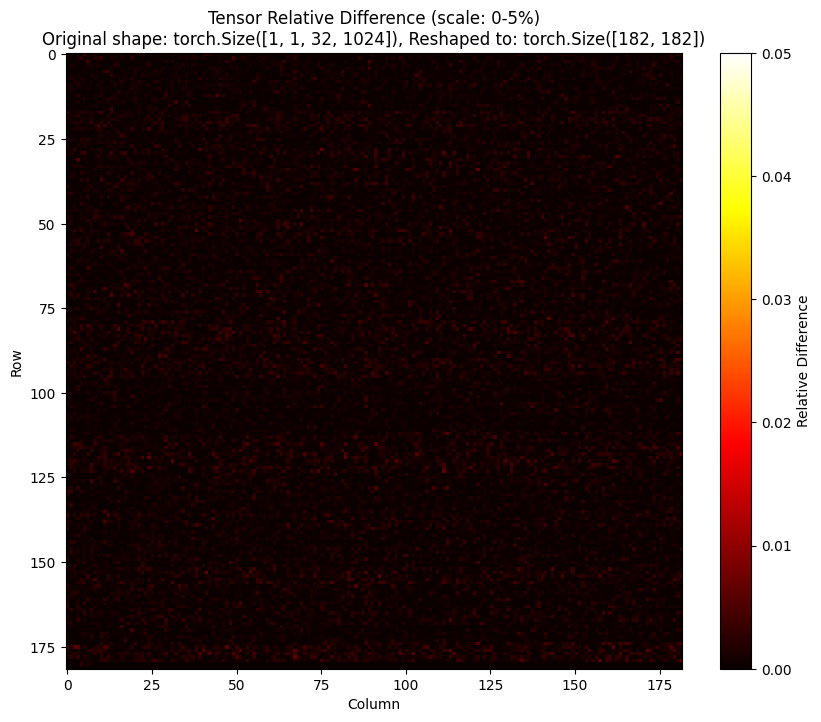

(tensor([[[[1.6022e-04, 5.1763e-04, 3.9381e-04,  ..., 5.9281e-05,
            7.5909e-04, 2.8177e-04],
           [4.0995e-04, 3.4876e-05, 2.8022e-03,  ..., 1.3430e-05,
            6.4664e-04, 1.2656e-03],
           [3.5154e-04, 7.8025e-05, 5.8106e-04,  ..., 3.6923e-04,
            4.0752e-04, 4.8359e-04],
           ...,
           [3.3893e-04, 2.7743e-05, 5.7662e-04,  ..., 4.0031e-04,
            6.4814e-04, 9.8729e-05],
           [2.6768e-04, 3.4998e-04, 5.9244e-04,  ..., 9.6030e-05,
            3.5888e-04, 1.2536e-03],
           [3.2467e-03, 2.6067e-04, 2.2921e-03,  ..., 4.2187e-04,
            1.4937e-03, 6.3769e-04]]]]),
 tensor([[1.6022e-04, 5.1763e-04, 3.9381e-04,  ..., 3.6386e-06, 2.5966e-03,
          6.5667e-04],
         [1.2597e-03, 4.7418e-04, 1.8654e-04,  ..., 1.8637e-04, 8.3336e-06,
          6.8227e-04],
         [4.7074e-04, 1.3470e-05, 2.8628e-04,  ..., 9.9775e-04, 1.8030e-03,
          1.1413e-05],
         ...,
         [4.1481e-04, 4.1306e-04, 2.6005e-04,  ...,

In [10]:
compare_tensors_with_viz(output_ttml_t, output_pt)

Top 5 relative differences:
  1. Value: 2.558653e-02 at index (0, 0, 0, 746)
  2. Value: 2.478570e-02 at index (0, 0, 0, 959)
  3. Value: 2.283962e-02 at index (0, 0, 0, 544)
  4. Value: 2.037246e-02 at index (0, 0, 0, 525)
  5. Value: 1.837408e-02 at index (0, 0, 0, 109)


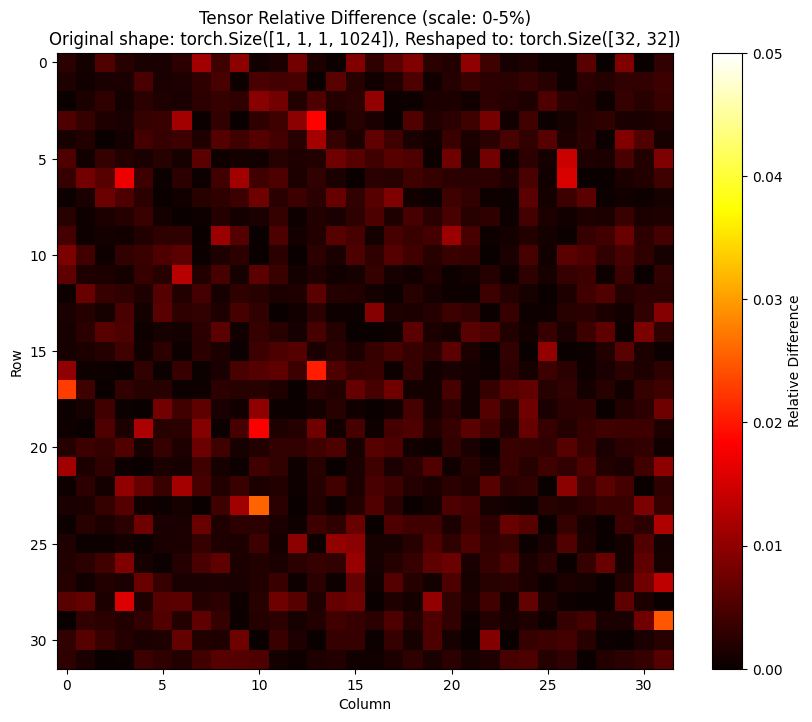

(tensor([[[[0.0025, 0.0009, 0.0054,  ..., 0.0024, 0.0031, 0.0055]]]]),
 tensor([[2.5064e-03, 8.6153e-04, 5.4144e-03,  ..., 8.9168e-03, 3.6806e-05,
          3.0608e-03],
         [1.5966e-03, 6.6776e-04, 1.3082e-03,  ..., 3.0625e-03, 2.9740e-03,
          3.7421e-03],
         [3.6076e-05, 1.4418e-03, 2.8016e-03,  ..., 3.2448e-03, 2.3210e-03,
          3.5374e-03],
         ...,
         [5.3773e-05, 3.0665e-03, 2.6318e-03,  ..., 1.2650e-03, 7.7558e-03,
          2.4786e-02],
         [2.9405e-03, 5.7371e-03, 3.5816e-03,  ..., 3.7524e-05, 1.2442e-03,
          2.2598e-03],
         [2.8299e-03, 1.3401e-03, 3.7359e-05,  ..., 2.4469e-03, 3.1396e-03,
          5.4850e-03]]))

In [11]:
compare_tensors_with_viz(gamma_grad_ttml_t, gamma_grad_pt.float())

Top 5 relative differences:
  1. Value: 6.483169e-03 at index (0, 0, 12, 178)
  2. Value: 6.458608e-03 at index (0, 0, 12, 817)
  3. Value: 6.355376e-03 at index (0, 0, 12, 238)
  4. Value: 6.078260e-03 at index (0, 0, 12, 16)
  5. Value: 5.881724e-03 at index (0, 0, 12, 103)


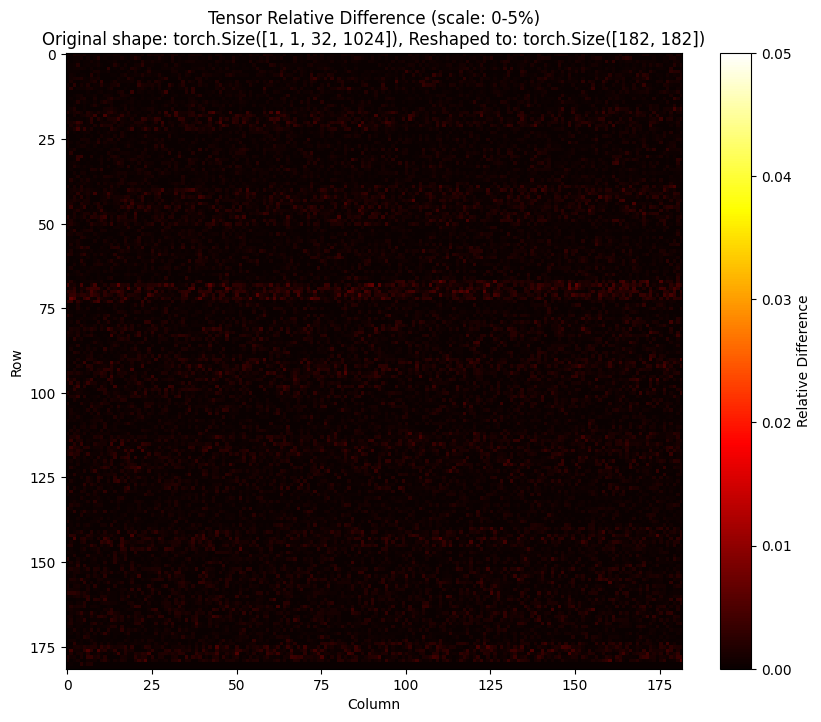

(tensor([[[[3.2020e-04, 3.6912e-05, 1.0979e-03,  ..., 3.6486e-04,
            2.5909e-04, 2.9623e-04],
           [7.6566e-05, 4.1047e-05, 2.1149e-03,  ..., 6.4974e-04,
            8.0837e-05, 2.1387e-03],
           [1.0579e-04, 5.8295e-04, 4.4621e-04,  ..., 1.7862e-04,
            1.3198e-03, 3.8298e-04],
           ...,
           [9.7980e-04, 5.4138e-04, 2.4299e-05,  ..., 1.1133e-04,
            3.0416e-03, 2.0394e-04],
           [3.3070e-04, 2.5075e-04, 8.8088e-04,  ..., 2.7121e-04,
            1.2122e-04, 2.2005e-03],
           [2.4266e-03, 2.0847e-03, 2.8838e-03,  ..., 4.8279e-04,
            1.4078e-03, 1.7326e-03]]]]),
 tensor([[3.2020e-04, 3.6912e-05, 1.0979e-03,  ..., 5.5058e-05, 1.5362e-03,
          2.0210e-04],
         [1.7334e-04, 1.2883e-04, 3.5216e-04,  ..., 1.3251e-03, 4.8052e-04,
          3.4492e-05],
         [6.3324e-04, 1.0978e-04, 2.0384e-04,  ..., 8.8348e-04, 6.9127e-04,
          1.3369e-04],
         ...,
         [1.5412e-03, 1.6424e-04, 4.5605e-04,  ...,

In [12]:
compare_tensors_with_viz(x_pt.grad, x_grad_ttml_t)